In [ ]:
from bs4 import BeautifulSoup
import requests
import warnings
import random
import string
import time

warnings.filterwarnings('ignore')

TIMEOUT = 5
CNET_BASE_URL = 'https://www.cnet.com'

def fetch_webpage(url, retry_count=5):
    html = None
    while not html and retry_count > 0:
        try:
            html = requests.get(url, verify=False, timeout=TIMEOUT).content
        except requests.exceptions.RequestException:
            print('Could not connect to {}. Retry count: {}'.format(url, retry_count))
            retry_count -= 1
    return html

def get_review_links(html):
    soup = BeautifulSoup(html, 'lxml')
    links = [(p.select('.itemInfo h3')[0].get_text(), 
              CNET_BASE_URL+p.select('a.imageWrap')[0]['href']) 
             for p in soup.select('section.product')]
    #links = [CNET_BASE_URL + a['href'] 
    #         for a in soup.select('section.product a.imageWrap')]
    return links

def get_review_page(html):
    soup = BeautifulSoup(html, 'lxml')
    [s.extract() for s in soup(['script', 'figure'])]
    text = soup.find_all(['p', 'ul'], attrs={'class': None})
    #text = soup.select('#editorReview > p, #editorReview > ul > li')
    text = None if len(text) == 0 else '\n\n'.join(['\n'.join(t.strings) for t in text])
    next_page = soup.select('a.nextPage')
    next_page = None if len(next_page) == 0 or next_page[0]['rel'][0] == 'prev' else CNET_BASE_URL + next_page[0]['href']
    return text, next_page

def get_full_review(first_page_url):
    full_review = ''
    review_title = BeautifulSoup(fetch_webpage(first_page_url))
    review_title = review_title.select('.headline')
    if len(review_title) > 0:
        review_title = review_title[0]
        review_title = review_title.get_text().strip()
    else:
        review_title = 'NO TITLE [{}]'.format(uuid())
    next_page = first_page_url
    while next_page:
        html = fetch_webpage(next_page)
        text, next_page = get_review_page(html)
        full_review += '\n\n' + (text if text else '')
    return full_review, review_title
        
def uuid():
    return ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

reviews = {}
html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/')
links = get_review_links(html)
print('Page: 1')
for link in links:
    review, key = get_full_review(link[1])
    if key in reviews:
        key = key + ' ({})'.format(uuid())
    reviews[key] = (link, review)
    time.sleep(1)
"""    
for i in range(2, 158):
    print('Page:', i)
    html = fetch_webpage('https://www.cnet.com/topics/smart-home/products/{}/'.format(i))
    links = get_review_links(html)
    for link in links:
        review, key = get_full_review(link[1])
        if key in reviews:
            key = key + ' ({})'.format(uuid())
        reviews[key] = (link, review)
        time.sleep(1)
"""

In [ ]:
print(reviews)

In [ ]:
import pickle

with open('cnet-reviews.pickle', 'wb') as f:
    pickle.dump(reviews, f)

In [ ]:
import pickle

with open('cnet-reviews.pickle', 'rb') as f:
    reviews = pickle.load(f)

In [ ]:
import csv

with open('cnet.csv', 'w') as f:
    writer = csv.writer(f, delimiter='|')
    for k,v in reviews.items():
        writer.writerow([v[0][0], v[0][1], k, v[1]])

In [ ]:
sample_reviews = {}
keys = list(reviews.keys())
for i in range(0, 628, 13):
    sample_reviews[keys[i]] = reviews[keys[i]]

# Analysis

In [1]:
import pandas as pd
import analyze_text as atxt
%matplotlib inline

# Prepare text
df = pd.read_csv('cnet-classifications.csv')
df['labels_factor'] = pd.factorize(df['device_category'])[0]
all_scores = {}

In [2]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary.load('cnet-65_dictionary.gensim')
ldamodel = LdaModel.load('cnet-65_model.gensim')

In [ ]:
# LDA
NUM_TOPICS = 65

texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['article_content']]
ldamodel = atxt.run_lda(texts_tokens, 
             dictionary_save_name='cnet-{}_dictionary.gensim'.format(NUM_TOPICS),
             corpus_save_name='cnet-{}_corpus.pkl'.format(NUM_TOPICS), 
             model_save_name='cnet-{}_model.gensim'.format(NUM_TOPICS), 
             num_topics=NUM_TOPICS,
             print_topics=False)

In [5]:
# HDP
from gensim.models.hdpmodel import HdpModel
from gensim import corpora

texts_tokens = [atxt.prepare_text_for_lda(text) 
                for text in df['article_content']]
dictionary = corpora.Dictionary(texts_tokens)
corpus = [dictionary.doc2bow(text) for text in texts_tokens]
hdpmodel = HdpModel(corpus, dictionary)

In [10]:
shown_topics = hdpmodel.show_topics(formatted=False)
topics_nos = [x[0] for x in shown_topics]
weights = [sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos]
pd.DataFrame({'topic_id':topics_nos, 'weight':weights}).sort_values(by='weight')

    topic_id    weight
14        14  0.027812
19        19  0.028298
17        17  0.029310
13        13  0.029769
10        10  0.030033
15        15  0.030426
18        18  0.030643
12        12  0.030786
16        16  0.031535
11        11  0.039028
9          9  0.040408
7          7  0.045678
8          8  0.047940
6          6  0.048055
4          4  0.050276
5          5  0.057507
3          3  0.064979
2          2  0.085463
1          1  0.114114
0          0  0.130579

In [ ]:
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import seaborn as sb
import math
import textwrap

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))

dictionary = Dictionary.load('cnet-65_dictionary.gensim')
df_sample = df.sample(n=NUM_SAMPLES).reset_index()
for i, row in df_sample.iterrows():
    data = []
    prepared_text = atxt.prepare_text_for_lda(row['article_content'])
    #print(row['device_name'])
    #print(prepared_text)
    docbow = dictionary.doc2bow(prepared_text)
    topics = ldamodel.get_document_topics(docbow)
    for topic_id, score in topics:
        terms = ldamodel.get_topic_terms(topic_id, topn=3)
        label = '\n'.join([dictionary.get(t) for t,_ in terms])
        data.insert(0, {'label': label, 'score': score})
        #print(label.replace('\n', ';'), topic_id)
    #print('-----')
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='label', y='score', data=plt_df,
                         ax=ax[ax_x, ax_y], ci=None)
    ax[ax_x, ax_y].set_title(textwrap.fill(row['device_name'] + ' ({})'.format(row['device_category'], 15)))
    plt.tight_layout()

In [ ]:
from collections import defaultdict

counts = defaultdict(lambda: 0)
num_topics = {}
for i, row in df.iterrows():
    prepared_text = atxt.prepare_text_for_lda(row['article_content'])
    docbow = dictionary.doc2bow(prepared_text)
    topics = ldamodel.get_document_topics(docbow)
    n_t = 0
    for topic_id, score in topics:
        if score > 0.2:
            counts[topic_id] += 1
            n_t += 1
    num_topics[i] = n_t

In [ ]:
plt.figure(figsize=(20, 10))

counts_df = pd.DataFrame(list(counts.items()))
counts_df.columns = ['id', 'count']
counts_df['label'] = counts_df['id'].apply(lambda i: ', '.join([dictionary.get(t) for t,_ in ldamodel.get_topic_terms(i, topn=3)]))
#counts_df['id'] = counts_df['id'].apply(lambda i: '"'+str(i)+'"')
counts_df = counts_df.sort_values('count', ascending=False)
sb.barplot(data=counts_df, x='label', y='count', ci=None)

plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

counts_df = pd.DataFrame(list(num_topics.items()))
counts_df.columns = ['id', 'count']
counts_df['label'] = counts_df['id'].apply(lambda i: df.iloc[i]['device_name'])
counts_df['id'] = counts_df['id'].apply(lambda i: '"'+str(i)+'"')
counts_df = counts_df.sort_values('count', ascending=False)
sb.barplot(data=counts_df, x='label', y='count', ci=None)

plt.tight_layout()

counts_df.head(10)

In [ ]:
prepared_text = atxt.prepare_text_for_lda(df.iloc[424]['article_content'])
print(prepared_text)
docbow = dictionary.doc2bow(prepared_text)
topics = ldamodel.get_document_topics(docbow)
for t, s in topics:
    print(s)
    [print(dictionary.get(t)) for t,_ in ldamodel.get_topic_terms(t, topn=3)]
    print('----')

In [ ]:
[print(dictionary.get(t)) for t,_ in ldamodel.get_topic_terms(50)]

In [89]:
# TF-IDF
texts = [tuple(r) for r in df[['device_name', 'article_content', 'labels_factor']].values]
feature_names, feature_indices, tfidf_scores, tfidf_matrix, tfidf_kmeans, tfidf_sph_kmeans = atxt.run_tfidf(texts, num_clusters=20, rand_score=False, draw_graph=False, max_df=1.0)

In [90]:
tfidf_scores = {k:list(v) for k,v in tfidf_scores.items()}

KeyboardInterrupt: 

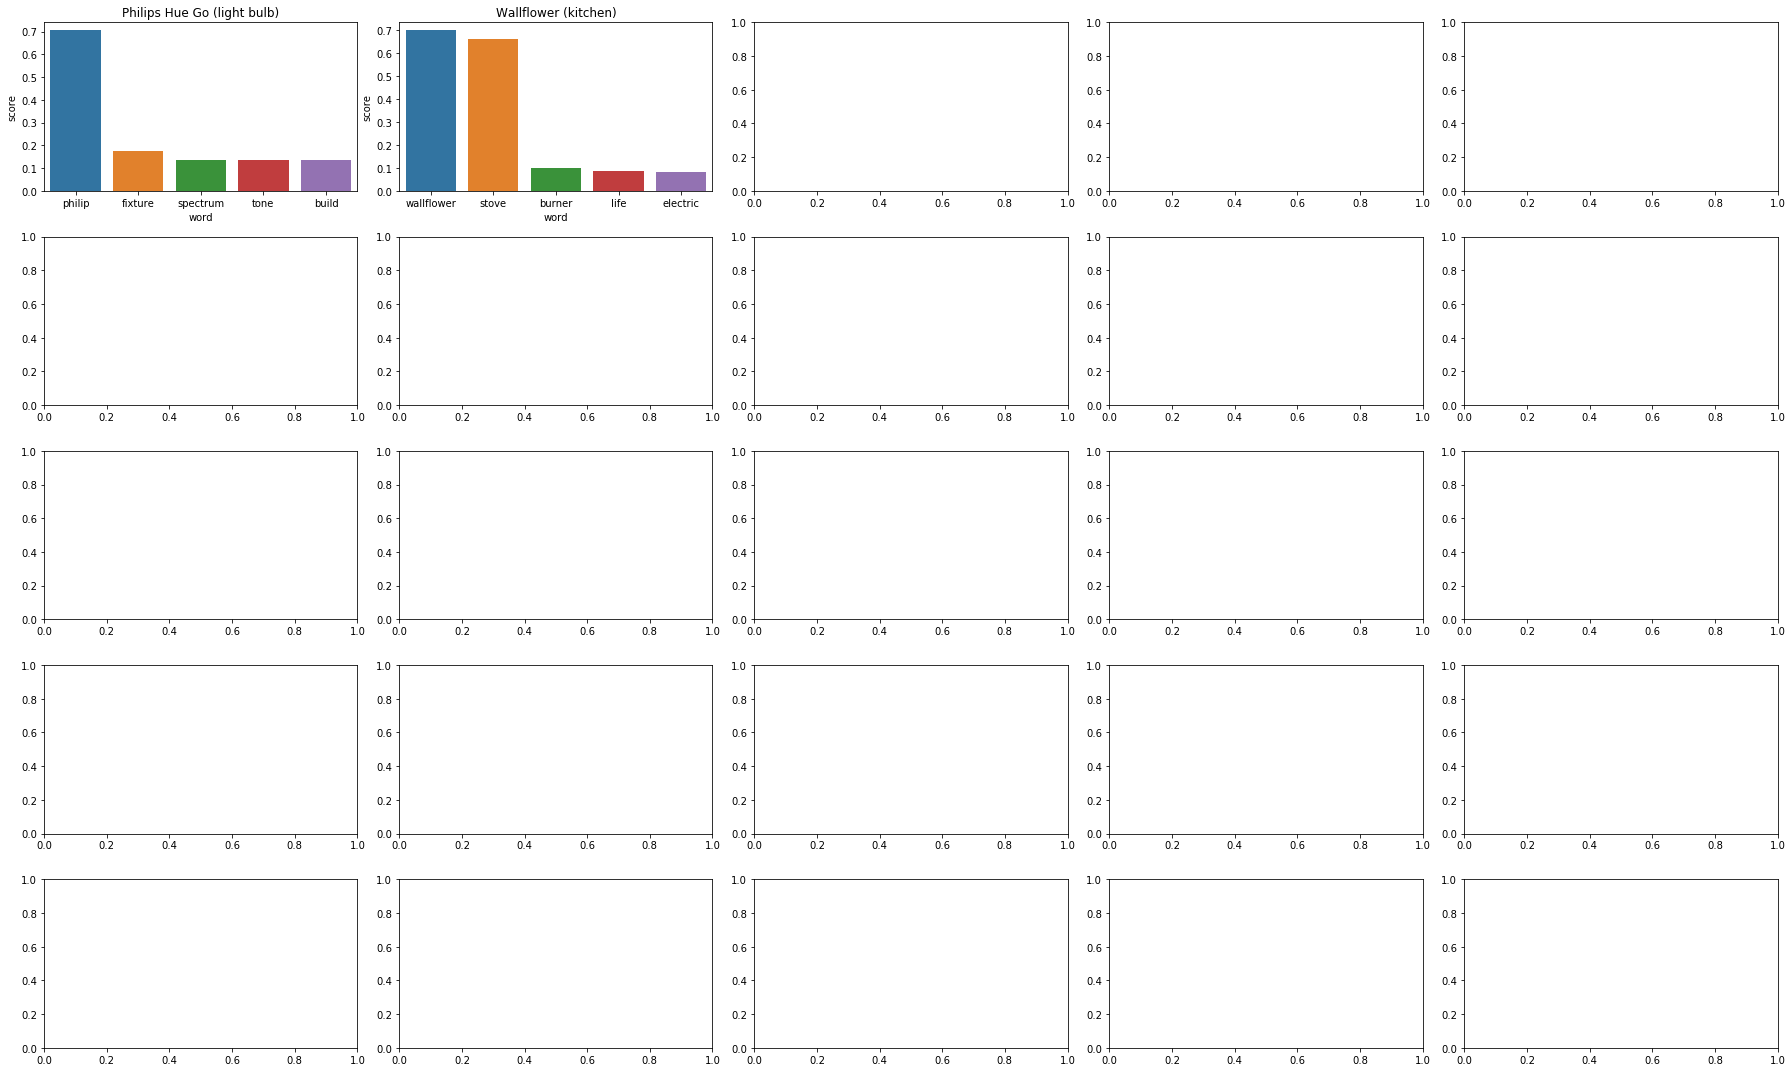

KeyboardInterrupt: 

In [25]:
import random
import matplotlib.pyplot as plt
import seaborn as sb
import math
import textwrap

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))
sorted_tfidf = {k: sorted(v, key=lambda x: x[1], reverse=True)[0:5] for k,v in tfidf_scores.items()}

for i, (k, v) in enumerate(random.sample(sorted_tfidf.items(), NUM_SAMPLES)):
    data = []
    for word_id, score in v:
        word = feature_names[word_id]
        data.insert(0, {'word': word, 'score': score})
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='word', y='score', data=plt_df, ax=ax[ax_x, ax_y],
                         ci=None)
    ax[ax_x, ax_y].set_title(textwrap.fill(df.iloc[k]['device_name'] + ' ({})'.format(df.iloc[k]['device_category'], 40)))
    plt.tight_layout()

In [91]:
import numpy as np
from IPython.display import display

df['cluster'] = tfidf_kmeans.labels_
km_list = []
for num, devices in df.groupby('cluster'):
    km_list.insert(0, {'cluster': num, 'text': '\n\n'.join(list(devices['article_content']))})
    print('Cluster number '+str(num))
    with pd.option_context('display.colheader_justify', 'left'):
        display(devices[['device_name', 'device_category']])
    print()

Cluster number 0


,device_name,device_category
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
4,Friday Smart Lock,smart lock
17,igloohome Smart Deadbolt 02,smart lock
45,Otto Smart Lock,smart lock
123,Kwikset Convert Smart Lock Conversion Kit,smart lock
128,Yale Assure Keyless Bluetooth Smart Lock,smart lock
200,Kwikset Premis,smart lock
217,Kwikset Kevo 2nd Gen Bluetooth Smart Lock,smart lock
222,Gate Labs Gate,smart lock
229,Smart Armor Smart Cube,smart lock



Cluster number 1


,device_name,device_category
29,Delta Leak Detector,leak detector
69,Halo Smart Labs Halo+ Smart Smoke & CO Alarm w...,air hazard
177,Netatmo Smart Smoke Alarm,air hazard
205,Roost Smart Smoke Alarm RSA-400,air hazard
249,Bosch Twinguard,air hazard
321,Kidde RemoteLync Monitor,air hazard
329,First Alert OneLink Wi-Fi Smoke and CO Alarm,air hazard
340,Halo Smart Labs Halo Smoke Alarm,air hazard
358,mydlink Smart Alarm Detector,air hazard
428,Lumkani Fire Detector,air hazard



Cluster number 2


,device_name,device_category
1,Feit Electric 6.5W Vintage Style LED,light bulb
19,Philips 60W Replacement WarmGlow Clear LED,light bulb
31,Cree 100W Replacement BR30 Floodlight LED,light bulb
44,Philips SceneSwitch BR30 LED,light bulb
101,Hyperikon 60W Equivalent LED,light bulb
133,GE 60W Equivalent HD Light LED,light bulb
287,Utilitech Pro 60W Equivalent LED,light bulb
310,Philips 40W Equivalent Candelabra LED,light bulb
337,GE 40W Replacement Vintage-Style Filament LED2...,light bulb
366,GE Bright Stik 100W Replacement LED2-pack,light bulb



Cluster number 3


,device_name,device_category
20,August Doorbell Cam Pro,doorbell
67,Ring Video Doorbell 2,doorbell
73,Ring Video Doorbell Pro,doorbell
228,Ding Smart Doorbell,doorbell
237,SkyBell Trim Plus,doorbell
240,Yale Look Video Doorbell,doorbell
306,August Doorbell Cam,doorbell
469,Bird Home Automation DoorBird Video Doorbell,doorbell
475,SkyBell Video Doorbell,doorbell
495,BOT Home Automation Ring,doorbell



Cluster number 4


,device_name,device_category
0,1-Ring Moon,camera
8,Lynky,assistant speaker
10,Cherry Labs Cherry Home,security system
11,Amazon Echo2017,assistant speaker
12,Harman Kardon Invoke,assistant speaker
13,HOPii,beer brewer
18,Smart Refrigerators,refrigerator
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator
27,Lifx Tile,light bulb
32,Fabriq Chorus Smart Speaker with Amazon Alexa,speaker



Cluster number 5


,device_name,device_category
3,Honeywell Smart Home Security System,security system
7,Wink Lookout,security system
24,Ring Protect,security system
25,Samsung SmartThings ADT Home Security Starter Kit,security system
43,TruSense,house monitor kit
66,Xfinity Home,security system
76,Hive Welcome Home Standard,starter kit
78,Loop Labs Notion,house monitor kit
84,Dojo,security system
99,Aura,security system



Cluster number 6


,device_name,device_category
85,LeakSmart Complete Home Water Protection System,leak detector
113,Roost Smart Water Leak and Freeze Detector,leak detector
208,Everspring Z-Wave Wireless Flood Detector,leak detector
209,Samsung SmartThings Water Leak Sensor,leak detector
210,Aeon Labs Aeotec Water Sensor,leak detector
211,D-Link Wi-Fi Water Sensor,leak detector
212,Honeywell Lyric Wi-Fi Leak and Freeze Detector,leak detector
272,Roost Smart Water and Freeze Detector,leak detector
277,Aquanta,home water monitor
373,FortrezZ Water and Freeze Alarm,leak detector



Cluster number 7


,device_name,device_category
111,BloomSky Sky2 Weather Camera Station,weather station
227,Netatmo Healthy Home Coach,air quality
263,BloomSky Plus,weather station
410,Netatmo Wind Gauge,weather station
560,BloomSky,weather station
573,Netatmo Weather Station,weather station



Cluster number 8


,device_name,device_category
36,Nest Thermostat E,thermostat
59,Lennox iComfort E30 Smart Thermostat,thermostat
90,Emerson Sensi Touch Wi-Fi Thermostat,thermostat
98,Ecobee4 Smart Thermostat,thermostat
127,Lux Geo Thermostat,thermostat
186,Carrier Cor 5C Thermostat,thermostat
221,Honeywell Lyric T5 Wi-Fi Thermostat,thermostat
226,Ecobee3 Lite Smart Thermostat,thermostat
230,Emerson Sensi Wi-Fi Programmable Thermostat,thermostat
243,Emerson 1F78-151 Thermostat,thermostat


Cluster number 9


,device_name,device_category
166,ShadeCraft Sunflower,shade
225,Wink Hub 2,hub
300,Wazombi Smart Shades,shade
304,FlipFlic,shade
318,BrewJacket Immersion Pro,kitchen
325,Lutron Serena Remote Controlled Shades,shade
335,Somfy myLink,shade
391,Axis Gear,shade
404,Oasys,home water monitor
422,SunPort,outlet



Cluster number 10


,device_name,device_category
15,GardenSpace,garden monitor
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
106,Sprinkl Conserve,sprinkler
308,Blossom 8 Smart Watering Controller,sprinkler
350,Edyn Water Valve,garden monitor
374,Etwater,sprinkler
419,Edyn Garden Sensor,garden monitor
423,Mist Labs Mist Sprinkler System,sprinkler



Cluster number 11


,device_name,device_category
81,TrackR Pixel,tracker
377,TrackR Atlas,tracker
492,TrackR Bravo,tracker



Cluster number 12


,device_name,device_category
50,iDevices Dimmer Switch,light switch
112,iDevices Wall Outlet,outlet
168,Incipio CommandKit Wi-Fi Switch,light switch
169,Incipio CommandKit Wi-Fi Power Strip,outlet
194,iDevices Instant Switch,light switch
262,iDevices Socket,light bulb
317,Elgato Eve Energy Switch & Power Meter,outlet
336,Grid Connect ConnectSense Smart Outlet,outlet
382,Nyrius Smart Outlet,outlet
393,GE Z-Wave Plug-In Smart Switch,outlet


Cluster number 13


,device_name,device_category
5,Noon Smart Lighting Starter Kit,light bulb
63,Leviton Decora Smart Dimmer with HomeKit,light switch
83,Belkin WeMo Dimmer Wi-Fi Light Switch,light switch
87,"Belkin WeMo Bridge, HomeKit-enabled",bridge
114,Sense Home Energy Monitor,energy monitor
131,Brilliant Control,light switch
140,Belkin WeMo Mini Wi-Fi Smart Plug,outlet
142,Curb Whole-Home Energy Monitoring,energy monitor
174,Switchmate Power,outlet
175,Switchmate Bright,light switch



Cluster number 14


,device_name,device_category
6,Amazon Echo Plus,assistant speaker
16,Sylvania Smart Plus Zigbee LED,light bulb
23,Lifx Beam,light bulb
30,Lifx Mini Wi-Fi Smart Bulb,light bulb
33,C by GE Lamp with Alexa,assistant speaker
34,Wiz Color Wi-Fi Smart LED Starter Kit,light bulb
53,Sylvania Smart Multicolor LED,light bulb
58,Oomi Home Starter Kit,starter kit
93,Ikea Tradfri Smart Lighting Kit,light bulb
117,Philips Hue White and Color Ambiance Candle,light bulb



Cluster number 15


,device_name,device_category
155,DockATot CloudTot,baby monitor
158,4moms Moxi Stroller,stroller
159,Happiest Baby Snoo,baby monitor
172,Fisher-Price Think and Learn Smart Cycle,toy
181,C-Way Memoo,toy
192,Aristotle by Nabi,assistant speaker
193,First Alert Onelink Environment Monitor,air quality
251,Project Nursery Video Baby Monitor System,baby monitor
252,Summer Infant In View Digital Color Video Baby...,baby monitor
253,Panasonic Wireless Home Baby Monitor Kit KX-HN...,baby monitor



Cluster number 16


,device_name,device_category
9,Guardzilla 360,camera
14,Remo+ DoorCam,camera
21,Netgear Arlo Pro 2,camera
22,Vivint Smart Home,security system
35,Tend Secure Lynx Solar Outdoor Camera,camera
51,Reolink Argus Security Camera,camera
54,Honeywell Lyric C1 Wi-Fi Security Camera,camera
55,SimpliSafe SimpliCam,camera
62,Ring Spotlight Cam,camera
68,Nest Cam IQ Indoor Security Camera,camera



Cluster number 17


,device_name,device_category
224,iSmartAlarm iCamera Keep Pro,camera
241,People Power Presence 360,security system
333,Zmodo Pivot,camera
380,iSmartAlarm Spot,camera
478,iSmartAlarm iCamera Keep,camera
614,Oplink Security TripleShield,security system
627,iSmartAlarm,security system



Cluster number 18


,device_name,device_category
235,Philips Hue White LED Starter Kit,light bulb
250,Philips Hue Motion Sensor,motion sensor
411,Philips Hue Lightstrip Plus,light bulb
415,Philips Hue Wireless Dimming Kit,light bulb
456,Philips Hue Go,light bulb
548,Philips Hue Lux,light bulb
567,Philips 60W Equivalent LEDSoft White,light bulb
591,Philips Clear LED,light bulb
615,Philips Hue BR30 Connected Downlight Lamps,light bulb
622,Philips Hue LightStrips,light bulb


Cluster number 19


,device_name,device_category
38,Panasonic Sustainable Maintainer,laundry
100,Nomiku Sous Chef,kitchen
130,Ezviz Mini 360 Plus,camera
137,Teforia Infuser,kitchen
141,Nutrismart,scale
223,Ezviz Mini Plus,camera
347,Ezviz Mini IQ,camera
348,Ezviz Mini Cube,camera
394,Ezviz Mini,camera


In [ ]:
# TF-IDF
km_df = pd.DataFrame(km_list)
texts = [tuple(r) for r in km_df.values]
feature_names, feature_indices, tfidf_scores, tfidf_matrix, kmeans = atxt.run_tfidf(texts, num_clusters=65, rand_score=False, draw_graph=True, max_df=1.0)

tfidf_scores = {k:list(v) for k,v in tfidf_scores.items()}

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sb
import math

NUM_SAMPLES = 25
fig, ax = plt.subplots(5, 5, figsize=(25, 15))
sorted_tfidf = {k: sorted(v, key=lambda x: x[1], reverse=True)[0:5] for k,v in tfidf_scores.items()}

for i, (k, v) in enumerate(random.sample(sorted_tfidf.items(), NUM_SAMPLES)):
    data = []
    for word_id, score in v:
        word = feature_names[word_id]
        data.insert(0, {'word': word, 'score': score})
    plt_df = pd.DataFrame(data).sort_values('score', ascending=False)
    ax_x = math.floor(i / math.sqrt(NUM_SAMPLES))
    ax_y = math.floor(i % math.sqrt(NUM_SAMPLES))
    barplot = sb.barplot(x='word', y='score', data=plt_df, ax=ax[ax_x, ax_y],
                         ci=None)
    plt.tight_layout()

In [147]:
# Doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from random import shuffle
from math import floor
import analyze_text as atxt

model = Doc2Vec(min_count=0, window=10, size=100, sample=10e-5, dm=0, negative=5,
                dbow_words=1, workers=2)

tagged_docs = []

# Collect the documents
for i, row in df.iterrows():
    if i % 100 == 0:
       print('Tagging document {}...'.format(i))
    texts_tokens = atxt.prepare_text_for_lda(row['article_content']) 
    doc_tag = 'DOC_{}'.format(i)
    tagged_docs.insert(0, TaggedDocument(texts_tokens, [doc_tag]))

# Train the model
model.build_vocab(tagged_docs)
for epoch in range(10):
    print('Beginning epoch {}...'.format(epoch))
    shuffle(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.iter)


Tagging document 0...


Tagging document 100...


Tagging document 200...


Tagging document 300...


Tagging document 400...


Tagging document 500...


Tagging document 600...


Beginning epoch 0...


Beginning epoch 1...


Beginning epoch 2...


Beginning epoch 3...


Beginning epoch 4...


Beginning epoch 5...


Beginning epoch 6...


Beginning epoch 7...


Beginning epoch 8...


Beginning epoch 9...


In [2]:
import pickle

#docvecs = model.docvecs
#with open('tagged-docs.pickle', 'wb') as f:
#    pickle.dump(tagged_docs, f)
#with open('docvecs.pickle', 'wb') as f:
#     pickle.dump(docvecs, f)

with open('tagged-docs.pickle', 'rb') as f:
     tagged_docs = pickle.load(f)
with open('docvecs.pickle', 'rb') as f:
     docvecs = pickle.load(f)

In [5]:
# Scores
from scipy.spatial.distance import cosine
import scipy
from sklearn.cluster import KMeans
from sklearn import metrics
from spherecluster import SphericalKMeans
import numpy as np
KM_VALUES = [5, 10, 15, 20, 25, 35, 50, 75, 100]

#TF-IDF
texts = [tuple(r) for r in df[['device_name', 'article_content', 'labels_factor']].values]

# Doc2Vec
# Collect all docvecs
all_docvecs = []
for i in range(len(tagged_docs)):
    all_docvecs.append(docvecs['DOC_{}'.format(i)].flatten())
all_docvecs = np.array(all_docvecs)

# Average 1-cos similarity b/w each inst and centroid for all inst
def avg_cos(X, model):
    avg = 0
    for i, vec in enumerate(X):
        label = model.labels_[i]
        centroid_vec = model.cluster_centers_[label]
        if scipy.sparse.issparse(vec):
           vec = vec.todense()
        avg += cosine(vec, centroid_vec)
    return avg / float(X.shape[0])


In [157]:
# Get the silhouette coefficients
km_labels = {}
km_labels['Doc2Vec'] = {}
km_labels['TF-IDF'] = {}
all_scores['Doc2Vec_KMeans'] = {}
all_scores['TF-IDF_KMeans'] = {}
all_scores['Doc2Vec_SphericalKMeans'] = {}
all_scores['TF-IDF_SphericalKMeans'] = {}
for val in KM_VALUES:
    print('Getting scores for {}'.format(val))
    _, _, _, tfidf_matrix, tfidf_kmeans, tfidf_sph_kmeans = atxt.run_tfidf(texts, num_clusters=val, rand_score=False, draw_graph=False, max_df=1.0)
    km_labels['TF-IDF'][val] = tfidf_kmeans.labels_
    all_scores['TF-IDF_KMeans'][val] = avg_cos(tfidf_matrix, tfidf_kmeans)
    all_scores['TF-IDF_SphericalKMeans'][val] = avg_cos(tfidf_matrix, tfidf_sph_kmeans)
    doc2vec_kmeans = KMeans(n_clusters=val, random_state=0).fit(all_docvecs)
    doc2vec_sph_kmeans = SphericalKMeans(n_clusters=val, random_state=0).fit(all_docvecs)
    km_labels['Doc2Vec'][val] = doc2vec_kmeans.labels_
    all_scores['Doc2Vec_KMeans'][val] = avg_cos(all_docvecs, doc2vec_kmeans)
    all_scores['Doc2Vec_SphericalKMeans'][val] = avg_cos(all_docvecs, doc2vec_sph_kmeans)


Getting scores for 5


Getting scores for 10


Getting scores for 15


Getting scores for 20


Getting scores for 25


Getting scores for 35


Getting scores for 50


Getting scores for 75


Getting scores for 100


In [152]:
with open('all-scores.pickle', 'wb') as f:
     pickle.dump(all_scores, f)

#with open('all-scores.pickle', 'rb') as f:
#     all_scores = pickle.load(f)

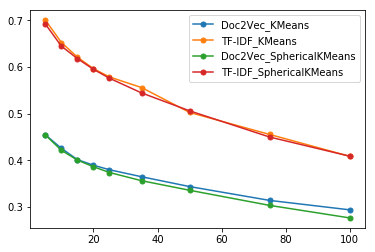

In [153]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# Plot it
for name, scores in all_scores.items():
    x, y = map(list, zip(*list(scores.items())))
    ax = plt.gca()
    plt.plot(x, y, label=name, marker='o', markersize=5)
    plt.legend(loc='upper right')


In [6]:
from IPython.display import display
from sklearn.cluster import KMeans
from spherecluster import SphericalKMeans

doc2vec_kmeans = KMeans(n_clusters=20, random_state=0).fit(all_docvecs)
doc2vec_sph_kmeans = SphericalKMeans(n_clusters=20, random_state=0).fit(all_docvecs)
df['d2v_km'] = doc2vec_kmeans.labels_
df['d2v_skm'] = doc2vec_sph_kmeans.labels_

print('Doc2Vec kmeans clusters (k=20)')
for num, devices in df.groupby('d2v_km'):
    print('Cluster number {}'.format(num))
    display(devices[['device_name', 'device_category']])

print()
print('=================================================================')
print()

print('Doc2Vec spherical kmeans clusters (k=20)')
for num, devices in df.groupby('d2v_skm'):
    print('Cluster number {}'.format(num))
    display(devices[['device_name', 'device_category']])


Doc2Vec kmeans clusters (k=20)
Cluster number 0


,device_name,device_category
36,Nest Thermostat E,thermostat
59,Lennox iComfort E30 Smart Thermostat,thermostat
90,Emerson Sensi Touch Wi-Fi Thermostat,thermostat
98,Ecobee4 Smart Thermostat,thermostat
127,Lux Geo Thermostat,thermostat
186,Carrier Cor 5C Thermostat,thermostat
221,Honeywell Lyric T5 Wi-Fi Thermostat,thermostat
226,Ecobee3 Lite Smart Thermostat,thermostat
230,Emerson Sensi Wi-Fi Programmable Thermostat,thermostat
243,Emerson 1F78-151 Thermostat,thermostat


Cluster number 1


,device_name,device_category
13,HOPii,beer brewer
18,Smart Refrigerators,refrigerator
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator
38,Panasonic Sustainable Maintainer,laundry
39,LG Lawn Mower Robot,lawn mower
42,Haier Link Cook Series,refrigerator
100,Nomiku Sous Chef,kitchen
125,Petnet SmartFeeder,pet
126,U by Moen Smart Shower,shower
137,Teforia Infuser,kitchen


Cluster number 2


,device_name,device_category
3,Honeywell Smart Home Security System,security system
41,Qihan Sanbot Nano,robot
84,Dojo,security system
222,Gate Labs Gate,smart lock
246,Tado Smart Radiator Thermostat,thermostat
292,Intraix KLUG Home,router
326,Orison Panel,energy storage
361,Ween,thermostat
376,Ulo,camera
377,TrackR Atlas,tracker


Cluster number 3


,device_name,device_category
95,ShapeScale,scale
152,Smart Nora,sleep
155,DockATot CloudTot,baby monitor
158,4moms Moxi Stroller,stroller
159,Happiest Baby Snoo,baby monitor
172,Fisher-Price Think and Learn Smart Cycle,toy
178,Bloomlife,woman health
181,C-Way Memoo,toy
182,Sensorwake Oria,sleep
236,LuDela Smart Candle,light bulb


Cluster number 4


,device_name,device_category
15,GardenSpace,garden monitor
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
80,Ambi Climate 2,AC
106,Sprinkl Conserve,sprinkler
308,Blossom 8 Smart Watering Controller,sprinkler
350,Edyn Water Valve,garden monitor
374,Etwater,sprinkler
423,Mist Labs Mist Sprinkler System,sprinkler


Cluster number 5


,device_name,device_category
27,Lifx Tile,light bulb
183,Luke Roberts Smart Lamp,light bulb
267,ilumi Smartstrip,light bulb
323,Spin-R Tittle Light Connected LED Lamp,light bulb
327,Qube Wi-Fi Multi-Color LED Smart Bulb,light bulb
352,iLumi BR30 Outdoor Smart LED Floodlight,light bulb
364,Big Ass Solutions Haiku L Series Ceiling Fan,fan
379,Ario Lamp,light bulb
411,Philips Hue Lightstrip Plus,light bulb
417,Mycroft Smart Home AI Platform,hub


Cluster number 6


,device_name,device_category
50,iDevices Dimmer Switch,light switch
63,Leviton Decora Smart Dimmer with HomeKit,light switch
74,Cnct IntelliPlug,outlet
110,Geeni Energi,outlet
112,iDevices Wall Outlet,outlet
140,Belkin WeMo Mini Wi-Fi Smart Plug,outlet
168,Incipio CommandKit Wi-Fi Switch,light switch
169,Incipio CommandKit Wi-Fi Power Strip,outlet
174,Switchmate Power,outlet
175,Switchmate Bright,light switch


Cluster number 7


,device_name,device_category
1,Feit Electric 6.5W Vintage Style LED,light bulb
19,Philips 60W Replacement WarmGlow Clear LED,light bulb
31,Cree 100W Replacement BR30 Floodlight LED,light bulb
44,Philips SceneSwitch BR30 LED,light bulb
101,Hyperikon 60W Equivalent LED,light bulb
132,Philips 60W Equivalent SceneSwitch LED,light bulb
133,GE 60W Equivalent HD Light LED,light bulb
287,Utilitech Pro 60W Equivalent LED,light bulb
310,Philips 40W Equivalent Candelabra LED,light bulb
311,Cree TW Series 40W Equivalent Candelabra LED,light bulb


Cluster number 8


,device_name,device_category
419,Edyn Garden Sensor,garden monitor
451,nthing Planty,garden monitor
467,Digital Spring Daisy,garden monitor
572,"Koubachi Wi-Fi Plant Sensor, Outdoor",garden monitor
577,Parrot Flower Power,garden monitor
580,Oso Technologies PlantLink,garden monitor


Cluster number 9


,device_name,device_category
9,Guardzilla 360,camera
51,Reolink Argus Security Camera,camera
54,Honeywell Lyric C1 Wi-Fi Security Camera,camera
55,SimpliSafe SimpliCam,camera
68,Nest Cam IQ Indoor Security Camera,camera
88,Olive & Dove RemoCam,camera
91,Tend Secure Lynx Indoor Camera,camera
94,Lighthouse Interactive Assistant,camera
102,Ring Floodlight Cam,camera
122,Samsung SmartCam PT,camera


Cluster number 10


,device_name,device_category
20,August Doorbell Cam Pro,doorbell
67,Ring Video Doorbell 2,doorbell
73,Ring Video Doorbell Pro,doorbell
89,Olive & Dove RemoBell,doorbell
120,Zmodo Torch Pro,camera
228,Ding Smart Doorbell,doorbell
237,SkyBell Trim Plus,doorbell
239,Nest Cam Outdoor,camera
294,Kuna Light Fixture,light bulb
306,August Doorbell Cam,doorbell


Cluster number 11


,device_name,device_category
22,Vivint Smart Home,security system
29,Delta Leak Detector,leak detector
43,TruSense,house monitor kit
46,Wallflower,kitchen
66,Xfinity Home,security system
76,Hive Welcome Home Standard,starter kit
78,Loop Labs Notion,house monitor kit
85,LeakSmart Complete Home Water Protection System,leak detector
99,Aura,security system
109,Abode Starter Kit,security system


Cluster number 12


,device_name,device_category
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
4,Friday Smart Lock,smart lock
17,igloohome Smart Deadbolt 02,smart lock
45,Otto Smart Lock,smart lock
60,Liftmaster Automatic Garage Door Lock,smart lock
71,Shortcut Labs Flic Hub,smart button
81,TrackR Pixel,tracker
103,Logitech Pop Smart Button Kit HomeKit-Enabled,smart button
108,Singlecue Gen 2,gesture controller
123,Kwikset Convert Smart Lock Conversion Kit,smart lock


Cluster number 13


,device_name,device_category
52,Weber Genesis II E-310,kitchen
104,Hestan Cue,kitchen
369,Pantelligent,kitchen
463,Anova Precision Cooker,kitchen


Cluster number 14


,device_name,device_category
6,Amazon Echo Plus,assistant speaker
16,Sylvania Smart Plus Zigbee LED,light bulb
23,Lifx Beam,light bulb
30,Lifx Mini Wi-Fi Smart Bulb,light bulb
34,Wiz Color Wi-Fi Smart LED Starter Kit,light bulb
53,Sylvania Smart Multicolor LED,light bulb
58,Oomi Home Starter Kit,starter kit
83,Belkin WeMo Dimmer Wi-Fi Light Switch,light switch
87,"Belkin WeMo Bridge, HomeKit-enabled",bridge
93,Ikea Tradfri Smart Lighting Kit,light bulb


Cluster number 15


,device_name,device_category
5,Noon Smart Lighting Starter Kit,light bulb
7,Wink Lookout,security system
10,Cherry Labs Cherry Home,security system
14,Remo+ DoorCam,camera
21,Netgear Arlo Pro 2,camera
24,Ring Protect,security system
25,Samsung SmartThings ADT Home Security Starter Kit,security system
35,Tend Secure Lynx Solar Outdoor Camera,camera
48,Nanoleaf Aurora Rhythm,light bulb
62,Ring Spotlight Cam,camera


Cluster number 16


,device_name,device_category
65,Mistbox2017,AC
82,Elgato Eve Degree,air quality
156,Breezi AirPulse,AC
189,Kérastase Hair Coach Powered by Withings,beauty
227,Netatmo Healthy Home Coach,air quality
238,Sevenhugs HugOne Sleep Tracking System,sleep
273,Philips Sonicare FlexCare Platinum Connected,toothbrush
314,Oral-B Genius 9000,toothbrush
316,Keen Home Smart Vent,AC
334,Flair Smart Vent,AC


Cluster number 17


,device_name,device_category
47,Eight Sleep Mars+ Smart Mattress,mattress
96,Serta iComfort TempTouch,mattress
97,Mode Modern Sunrise Smart Pillow,pillow
107,Cambridge Sound Management Nightingale,sleep
134,WinkBeds CoolControl,mattress
162,Habit,biometric analyzer
195,Sleep Number 360 Smart Bed,mattress
207,Sleep Number it,mattress
342,Nox Smart Sleep System,sleep
381,Juvo,sleep


Cluster number 18

,device_name,device_category
8,Lynky,assistant speaker
11,Amazon Echo2017,assistant speaker
12,Harman Kardon Invoke,assistant speaker
32,Fabriq Chorus Smart Speaker with Amazon Alexa,speaker
33,C by GE Lamp with Alexa,assistant speaker
37,iHome iAVS16 Alarm Clock with Amazon Alexa,alarm clock
40,Lenovo Home Assistant Pack,assistant speaker
56,Eufy Genie,assistant speaker
70,Amazon Echo Show,assistant speaker
72,Amazon Dash Wand with Alexa2017,barcode scanner


Cluster number 19


,device_name,device_category
0,1-Ring Moon,camera
61,Swidget Outlet,outlet
64,Intellithings RoomMe,motion sensor
92,Smalt,kitchen
105,LookOut Charger,camera
116,Storebound Sobro,furniture
121,Pebby,pet
241,People Power Presence 360,security system
248,Bosch 360 Degree Indoor Camera,camera
266,Ozmo Active Smart Cup,kitchen




Doc2Vec spherical kmeans clusters (k=20)
Cluster number 0


,device_name,device_category
2,Kwikset Obsidian Keywayless Smart Lock,smart lock
17,igloohome Smart Deadbolt 02,smart lock
45,Otto Smart Lock,smart lock
60,Liftmaster Automatic Garage Door Lock,smart lock
84,Dojo,security system
123,Kwikset Convert Smart Lock Conversion Kit,smart lock
128,Yale Assure Keyless Bluetooth Smart Lock,smart lock
200,Kwikset Premis,smart lock
217,Kwikset Kevo 2nd Gen Bluetooth Smart Lock,smart lock
282,Black+Decker Smartech Battery,battery


Cluster number 1


,device_name,device_category
23,Lifx Beam,light bulb
27,Lifx Tile,light bulb
47,Eight Sleep Mars+ Smart Mattress,mattress
48,Nanoleaf Aurora Rhythm,light bulb
96,Serta iComfort TempTouch,mattress
134,WinkBeds CoolControl,mattress
146,SolarGaps,solar panel
176,Hydrao First,shower
183,Luke Roberts Smart Lamp,light bulb
195,Sleep Number 360 Smart Bed,mattress


Cluster number 2

,device_name,device_category
38,Panasonic Sustainable Maintainer,laundry
39,LG Lawn Mower Robot,lawn mower
41,Qihan Sanbot Nano,robot
75,Amazon Echo Look,assistant speaker
79,Apple HomePod,assistant speaker
143,Seven Dreamers Laundroid,laundry
149,Mykie,assistant speaker
150,Ecovacs Robotics Unibot,cleaner
163,Black & Decker Smartech Robotic Vacuum,cleaner
166,ShadeCraft Sunflower,shade


Cluster number 3


,device_name,device_category
46,Wallflower,kitchen
61,Swidget Outlet,outlet
64,Intellithings RoomMe,motion sensor
81,TrackR Pixel,tracker
144,React,kitchen
174,Switchmate Power,outlet
175,Switchmate Bright,light switch
222,Gate Labs Gate,smart lock
229,Smart Armor Smart Cube,smart lock
268,Switchmate,light switch


Cluster number 4


,device_name,device_category
25,Samsung SmartThings ADT Home Security Starter Kit,security system
29,Delta Leak Detector,leak detector
43,TruSense,house monitor kit
69,Halo Smart Labs Halo+ Smart Smoke & CO Alarm w...,air hazard
78,Loop Labs Notion,house monitor kit
85,LeakSmart Complete Home Water Protection System,leak detector
113,Roost Smart Water Leak and Freeze Detector,leak detector
126,U by Moen Smart Shower,shower
156,Breezi AirPulse,AC
173,Ooma Home Monitoring System,security system


Cluster number 5


,device_name,device_category
20,August Doorbell Cam Pro,doorbell
67,Ring Video Doorbell 2,doorbell
68,Nest Cam IQ Indoor Security Camera,camera
73,Ring Video Doorbell Pro,doorbell
89,Olive & Dove RemoBell,doorbell
102,Ring Floodlight Cam,camera
120,Zmodo Torch Pro,camera
201,Ring Stick Up Cam,camera
220,Netatmo Presence,camera
228,Ding Smart Doorbell,doorbell


Cluster number 6


,device_name,device_category
13,HOPii,beer brewer
18,Smart Refrigerators,refrigerator
26,Samsung RF265BEAESR French Door Family Hub Ref...,refrigerator
42,Haier Link Cook Series,refrigerator
52,Weber Genesis II E-310,kitchen
100,Nomiku Sous Chef,kitchen
104,Hestan Cue,kitchen
125,Petnet SmartFeeder,pet
129,IGuardStove Intelligent,kitchen
137,Teforia Infuser,kitchen


Cluster number 7


,device_name,device_category
36,Nest Thermostat E,thermostat
59,Lennox iComfort E30 Smart Thermostat,thermostat
90,Emerson Sensi Touch Wi-Fi Thermostat,thermostat
98,Ecobee4 Smart Thermostat,thermostat
127,Lux Geo Thermostat,thermostat
131,Brilliant Control,light switch
186,Carrier Cor 5C Thermostat,thermostat
221,Honeywell Lyric T5 Wi-Fi Thermostat,thermostat
226,Ecobee3 Lite Smart Thermostat,thermostat
230,Emerson Sensi Wi-Fi Programmable Thermostat,thermostat


Cluster number 8


,device_name,device_category
6,Amazon Echo Plus,assistant speaker
8,Lynky,assistant speaker
11,Amazon Echo2017,assistant speaker
12,Harman Kardon Invoke,assistant speaker
32,Fabriq Chorus Smart Speaker with Amazon Alexa,speaker
33,C by GE Lamp with Alexa,assistant speaker
37,iHome iAVS16 Alarm Clock with Amazon Alexa,alarm clock
40,Lenovo Home Assistant Pack,assistant speaker
56,Eufy Genie,assistant speaker
70,Amazon Echo Show,assistant speaker


Cluster number 9


,device_name,device_category
1,Feit Electric 6.5W Vintage Style LED,light bulb
19,Philips 60W Replacement WarmGlow Clear LED,light bulb
31,Cree 100W Replacement BR30 Floodlight LED,light bulb
44,Philips SceneSwitch BR30 LED,light bulb
101,Hyperikon 60W Equivalent LED,light bulb
132,Philips 60W Equivalent SceneSwitch LED,light bulb
133,GE 60W Equivalent HD Light LED,light bulb
287,Utilitech Pro 60W Equivalent LED,light bulb
310,Philips 40W Equivalent Candelabra LED,light bulb
311,Cree TW Series 40W Equivalent Candelabra LED,light bulb


Cluster number 10


,device_name,device_category
95,ShapeScale,scale
151,iBaby Yobi,baby monitor
152,Smart Nora,sleep
155,DockATot CloudTot,baby monitor
158,4moms Moxi Stroller,stroller
159,Happiest Baby Snoo,baby monitor
160,Hubble Hugo,camera
172,Fisher-Price Think and Learn Smart Cycle,toy
178,Bloomlife,woman health
181,C-Way Memoo,toy


Cluster number 11


,device_name,device_category
182,Sensorwake Oria,sleep
216,Shortcut Labs FlicSingle Smart Button,smart button
236,LuDela Smart Candle,light bulb
277,Aquanta,home water monitor
292,Intraix KLUG Home,router
332,ComfyLight,light bulb
379,Ario Lamp,light bulb
382,Nyrius Smart Outlet,outlet
385,Xandem Home,security system
390,Locumi Monkey,smart lock


Cluster number 12


,device_name,device_category
4,Friday Smart Lock,smart lock
63,Leviton Decora Smart Dimmer with HomeKit,light switch
71,Shortcut Labs Flic Hub,smart button
74,Cnct IntelliPlug,outlet
82,Elgato Eve Degree,air quality
103,Logitech Pop Smart Button Kit HomeKit-Enabled,smart button
110,Geeni Energi,outlet
112,iDevices Wall Outlet,outlet
194,iDevices Instant Switch,light switch
202,iHome iSP8 SmartPlug,outlet


Cluster number 13


,device_name,device_category
3,Honeywell Smart Home Security System,security system
7,Wink Lookout,security system
9,Guardzilla 360,camera
14,Remo+ DoorCam,camera
21,Netgear Arlo Pro 2,camera
24,Ring Protect,security system
51,Reolink Argus Security Camera,camera
54,Honeywell Lyric C1 Wi-Fi Security Camera,camera
55,SimpliSafe SimpliCam,camera
88,Olive & Dove RemoCam,camera


Cluster number 14


,device_name,device_category
22,Vivint Smart Home,security system
66,Xfinity Home,security system
76,Hive Welcome Home Standard,starter kit
99,Aura,security system
109,Abode Starter Kit,security system
283,Home8 Smart Garage Starter Kit,starter kit
295,Iris by Lowe's Second Generation,starter kit
313,Alottazs Labs Garageio,garage opener
367,AT&T Digital Life,security system
387,Korner,security system


Cluster number 15


,device_name,device_category
16,Sylvania Smart Plus Zigbee LED,light bulb
30,Lifx Mini Wi-Fi Smart Bulb,light bulb
34,Wiz Color Wi-Fi Smart LED Starter Kit,light bulb
53,Sylvania Smart Multicolor LED,light bulb
117,Philips Hue White and Color Ambiance Candle,light bulb
135,TP-Link LB130 Multicolor Wi-Fi LED,light bulb
204,Lifx Plus Wi-Fi LED Smart Bulb,light bulb
219,Nanoleaf Aurora,light bulb
233,Lifx White 900 BR30 Wi-Fi LED Smart Bulb,light bulb
234,Lifx Color 1000 BR30 Wi-Fi LED Smart Bulb,light bulb


Cluster number 16


,device_name,device_category
97,Mode Modern Sunrise Smart Pillow,pillow
107,Cambridge Sound Management Nightingale,sleep
114,Sense Home Energy Monitor,energy monitor
142,Curb Whole-Home Energy Monitoring,energy monitor
258,Automatic Pro,car tracker
265,Wynd,air quality
331,Frigidaire Gallery Cool Connect,AC
363,QardioBase,scale
381,Juvo,sleep
404,Oasys,home water monitor


Cluster number 17


,device_name,device_category
15,GardenSpace,garden monitor
28,Blossom Smart Watering Controller,sprinkler
49,Orbit B-hyve,sprinkler
57,Rachio Smart Sprinkler Controller Generation 2,sprinkler
65,Mistbox2017,AC
80,Ambi Climate 2,AC
106,Sprinkl Conserve,sprinkler
308,Blossom 8 Smart Watering Controller,sprinkler
350,Edyn Water Valve,garden monitor
374,Etwater,sprinkler


Cluster number 18


,device_name,device_category
5,Noon Smart Lighting Starter Kit,light bulb
50,iDevices Dimmer Switch,light switch
58,Oomi Home Starter Kit,starter kit
83,Belkin WeMo Dimmer Wi-Fi Light Switch,light switch
87,"Belkin WeMo Bridge, HomeKit-enabled",bridge
93,Ikea Tradfri Smart Lighting Kit,light bulb
115,Leviton Decora Smart Wi-Fi Plug-In Dimmer,light switch
140,Belkin WeMo Mini Wi-Fi Smart Plug,outlet
168,Incipio CommandKit Wi-Fi Switch,light switch
169,Incipio CommandKit Wi-Fi Power Strip,outlet


Cluster number 19


,device_name,device_category
0,1-Ring Moon,camera
10,Cherry Labs Cherry Home,security system
35,Tend Secure Lynx Solar Outdoor Camera,camera
62,Ring Spotlight Cam,camera
92,Smalt,kitchen
94,Lighthouse Interactive Assistant,camera
105,LookOut Charger,camera
116,Storebound Sobro,furniture
121,Pebby,pet
138,Canary Flex,camera


In [7]:
# Use TF-IDF to get the most unique words for each doc2vec cluster
d2v_model_texts = {model: [(num, '\n\n'.join(group['article_content'].tolist())) for num, group in df.groupby(by='d2v_{}'.format(model))] for model in ['km', 'skm']}
d2v_model_tfidf = {model: atxt.run_tfidf(texts, num_clusters=20, rand_score=False, draw_graph=False, max_df=1.0)[:3:2] for model, texts in d2v_model_texts.items()}
d2v_model_tfidf = {model: {'id2name': model_scores[0], 'scores': {num: sorted(list(word_scores), key=lambda x: x[1], reverse=True)[:20] for num, word_scores in model_scores[1].items()}} for model, model_scores in d2v_model_tfidf.items()}


In [155]:
for model, results in d2v_model_tfidf.items():
    print(model)
    for num, word_scores in results['scores'].items():
        print('Cluster {}:'.format(num))
        for word_id, score in word_scores:
            print(results['id2name'][word_id], ' ({:.2f})'.format(score))
        print()
    print('============================')


km
Cluster 0:
thermostat  (0.69)
honeywell  (0.23)
lyric  (0.21)
smart  (0.21)
ecobee3  (0.20)
sensi  (0.14)
alexa  (0.14)
temperature  (0.14)
feature  (0.12)
cooling  (0.12)
heating  (0.11)
ecobee  (0.11)
geofencing  (0.11)
learning  (0.10)
homekit  (0.10)
ecobee4  (0.09)
design  (0.08)
vent  (0.07)
integration  (0.07)
model  (0.07)

Cluster 1:
smart  (0.22)
device  (0.19)
child  (0.18)
kuvée  (0.17)
sleep  (0.16)
bottle  (0.16)
price  (0.14)
sleeper  (0.14)
feature  (0.13)
cartridge  (0.12)
parent  (0.11)
bedjet  (0.11)
fisher  (0.11)
product  (0.11)
nightingale  (0.10)
charge  (0.10)
hopii  (0.10)
igulu  (0.10)
grocery  (0.10)
matrix  (0.09)

Cluster 2:
smart  (0.53)
control  (0.25)
light  (0.20)
switch  (0.18)
devices  (0.17)
product  (0.14)
voice  (0.13)
alexa  (0.12)
device  (0.12)
philip  (0.12)
bulb  (0.11)
homekit  (0.11)
amazon  (0.10)
bluetooth  (0.10)
belkin  (0.10)
switchmate  (0.09)
google  (0.09)
thermostat  (0.09)
price  (0.09)
power  (0.08)

Cluster 3:
bloomsky  (0.48)

In [146]:
ITEM_IDX = 303
CLUSTER_NUM = 1

l = atxt.prepare_text_for_lda(df.iloc[ITEM_IDX]['article_content'])
l = list(set(l))
scores = d2v_model_tfidf['km']['scores']
id2name = d2v_model_tfidf['km']['id2name']
vocab = list(set([id2name[w] for w,_ in scores[CLUSTER_NUM]]))
display([x for x in l if x in vocab])


['igulu', 'feature', 'price', 'product']

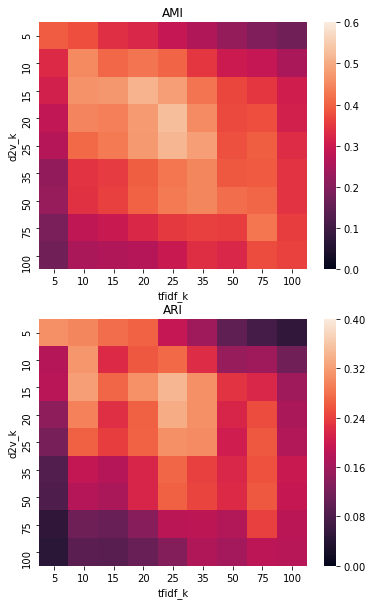

In [190]:
# TF-IDF vs Doc2Vec AMI at varying k
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import seaborn as sb
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def make_data_point(d2v_k, d2v_ls, tfidf_k, tfidf_ls):
    ami = adjusted_mutual_info_score(d2v_ls, tfidf_ls)
    ari = adjusted_rand_score(d2v_ls, tfidf_ls)
    return {'d2v_k': d2v_k, 'tfidf_k': tfidf_k, 'ami': ami, 'ari': ari}

d2v_items = km_labels['Doc2Vec'].items()
tfidf_items = km_labels['TF-IDF'].items()
product = itertools.product(d2v_items, tfidf_items)
data = [make_data_point(d_k, d_ls, t_k, t_ls) for (d_k, d_ls), (t_k, t_ls) in product]
data = pd.DataFrame(data)
ami_data = data.pivot('d2v_k', 'tfidf_k', 'ami')
ari_data = data.pivot('d2v_k', 'tfidf_k', 'ari')

fig, ax = plt.subplots(figsize=(6, 10), nrows=2)
ami_heatmap = sb.heatmap(ami_data, vmax=0.6, vmin=0, ax=ax[0])
ami_heatmap.set_title('AMI')
ari_heatmap = sb.heatmap(ari_data, vmax=0.4, vmin=0, ax=ax[1])
ari_heatmap.set_title('ARI')
